In [85]:
import os
import pandas as pd
import json
import glob
from matplotlib import pyplot as plt

In [86]:
def process_power_per_pod(folder_path):
    # Process power consumption data
    power_file = os.path.join(folder_path, "metrics_energy.json")
    uid_pod_map_file = os.path.join(folder_path, "uid_pod_mapping.csv")  # Now reading as a CSV

    # Load UID to Pod Name Mapping
    if os.path.exists(uid_pod_map_file):
        uid_pod_map = pd.read_csv(uid_pod_map_file)  # Read CSV into a DataFrame
        # Ensure the mapping DataFrame has expected columns
        if not {"UID", "Pod Name"}.issubset(uid_pod_map.columns):
            print("Invalid UID-Pod mapping format")
            return pd.DataFrame()  # Return an empty DataFrame
    else:
        print("No UID-Pod mapping file found")
        return pd.DataFrame()  # Return an empty DataFrame

    # Load Power Data
    if os.path.exists(power_file):
        with open(power_file, 'r') as f:
            power_data = json.load(f)
    else:
        print("No power data file found")
        return pd.DataFrame()  # Return an empty DataFrame
       
    # Collect timestamps and values for all pods
    rows = []
    for uid_suffix, data in power_data.items():
        # Map UID suffix to pod name using the DataFrame
        pod_name_row = uid_pod_map[uid_pod_map["UID"].str.endswith(uid_suffix)]
        if pod_name_row.empty:
            continue  # Skip if no matching UID is found
        pod_name = pod_name_row.iloc[0]["Pod Name"]  # Get the first match

        # Append each entry in the pod's power data to the rows list
        for entry in data:
            rows.append({
                "timestamp": entry["timestamp"],
                "pod_name": pod_name,
                "value": entry["value"]
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(rows)

    return df


In [87]:


def process_folder(folder_path):
    # Extract configuration from folder name
    folder_name = os.path.basename(folder_path)
    if "baseline_metrics" not in folder_name:
        requested_mbps, duration, packet_length= folder_name.split('_')
    else:
        # cpu_limit=0
        requested_mbps=0
        packet_length=0
        avg_mbps_received=0
    
    # cpu_usages = []
    # Process iperf server log
    server_files = glob.glob(os.path.join(folder_path, "log_iperf_server_*.csv"))
    if server_files:
        total_mbps_sum = 0  # Initialize total sum
        for server_file in server_files:
            df_server = pd.read_csv(server_file)
            # Calculate Mbps for the current file
            df_server['Mbps'] = df_server['Bitrate'] / 1e6  # Convert bps to Mbps
            total_mbps_sum += df_server['Mbps'].mean()  # Add mean Mbps for this file to the total sum
        
        # Final aggregated result
        avg_mbps_received = total_mbps_sum
    else:
        avg_mbps_received = 0  # Default value if no files found

    # # Process power consumption at node data
    # power_file = os.path.join(folder_path, "metrics_host_energy.json")
    # tot_power_consumption_host_baseline = 0
    # tot_power_consumption_host_experiment = 0
    # if os.path.exists(power_file):
    #     with open(power_file, 'r') as f:
    #         power_data = json.load(f)
        
    #     # Collect timestamps and values for CU container
    #     timestamps = []
    #     values = []
    #     for node_data in power_data.values():
    #         for entry in node_data:
    #             timestamps.append(entry['timestamp'])
    #             values.append(entry['value'])
               
    #     avg_power_consumption_host_baseline = sum(values[25:100]) / len(values[25:100]) if values[25:100] else 0
    #     tot_power_consumption_host_baseline += avg_power_consumption_host_baseline
    #     avg_power_consumption_host_experiment = sum(values[-50:-30]) / len(values[-50:-30]) if values[-50:-30] else 0
    #     tot_power_consumption_host_experiment += avg_power_consumption_host_experiment
        
    # else:
    #     tot_power_consumption_host = 0  # Default if no data found
    
    # Process pod-level power data using process_power_per_pod
    df_pod_power = process_power_per_pod(folder_path)
    
    # Initialize the power consumption variables for each pod type
    avg_power_oai_cu_baseline = 0  # Default if no data available
    avg_power_oai_cu_experiment = 0  # Default if no data available
    avg_power_oai_du_baseline = 0  # Default if no data available
    avg_power_oai_du_experiment = 0  # Default if no data available
    avg_power_oai_nr_ue_baseline = 0  # Default if no data available
    avg_power_oai_nr_ue_experiment = 0  # Default if no data available
    avg_power_oai_upf_baseline = 0  # Default if no data available
    avg_power_oai_upf_experiment = 0  # Default if no data available

    oai_cu_pods_sorted = pd.DataFrame()
    oai_du_pods_sorted = pd.DataFrame()
    oai_nr_ue_pods_sorted = pd.DataFrame()
    oai_upf_pods_sorted = pd.DataFrame()
    
    # Check if the column "pod_name" exists in the DataFrame
    if "pod_name" in df_pod_power.columns:
        # OAI-CU Pods
        oai_cu_pods = df_pod_power[df_pod_power["pod_name"].str.startswith("oai-cu")]
        if not oai_cu_pods.empty:
            oai_cu_pods_sorted = oai_cu_pods.sort_values(by="timestamp") # Sort by timestamp
            oai_cu_pods_filtered_baseline = oai_cu_pods_sorted.iloc[50:100]
            oai_cu_pods_filtered_experiment = oai_cu_pods_sorted.iloc[130:200] # Exclude the first and last interval_to_exclude timestamps
            avg_power_oai_cu_baseline = oai_cu_pods_filtered_baseline["value"].mean() # Calculate the average power for the filtered data
            avg_power_oai_cu_experiment = oai_cu_pods_filtered_experiment["value"].mean() # Calculate the average power for the filtered data
        else:
            avg_power_oai_cu_baseline = 0  # Default if no data available
            avg_power_oai_cu_experiment = 0  # Default if no data available
        # Aggregate power consumption for DUs
        oai_du_pods = df_pod_power[df_pod_power["pod_name"].str.startswith("oai-du")]
        if not oai_du_pods.empty:
            oai_du_pods_sorted = oai_du_pods.sort_values(by="timestamp")  # Sort by timestamp
            # Calculate mean for each DU individually and then sum up the results
            avg_power_oai_du_baseline = (
                oai_du_pods_sorted.groupby("pod_name")
                .apply(lambda group: group.iloc[50:100]["value"].mean())
                .sum()
            )
            avg_power_oai_du_experiment = (
                oai_du_pods_sorted.groupby("pod_name")
                .apply(lambda group: group.iloc[130:180]["value"].mean())
                .sum()
            )
        else:
            avg_power_oai_du_baseline = 0  # Default if no data available
            avg_power_oai_du_experiment = 0  # Default if no data available

        # Aggregate power consumption for NR-UEs
        oai_nr_ue_pods = df_pod_power[df_pod_power["pod_name"].str.startswith("oai-nr-ue")]
        if not oai_nr_ue_pods.empty:
            oai_nr_ue_pods_sorted = oai_nr_ue_pods.sort_values(by="timestamp")  # Sort by timestamp
            # Calculate mean for each UE individually and then sum up the results
            avg_power_oai_nr_ue_baseline = (
                oai_nr_ue_pods_sorted.groupby("pod_name")
                .apply(lambda group: group.iloc[50:100]["value"].mean())
                .sum()
            )
            avg_power_oai_nr_ue_experiment = (
                oai_nr_ue_pods_sorted.groupby("pod_name")
                .apply(lambda group: group.iloc[130:180]["value"].mean())
                .sum()
            )
        else:
            avg_power_oai_nr_ue_baseline = 0  # Default if no data available
            avg_power_oai_nr_ue_experiment = 0  # Default if no data available

        # UPF Pods
        oai_upf_pods = df_pod_power[df_pod_power["pod_name"].str.startswith("oai-upf")]
        if not oai_upf_pods.empty:
            oai_upf_pods_sorted = oai_upf_pods.sort_values(by="timestamp") # Sort by timestamp
            oai_upf_pods_filtered_baseline = oai_upf_pods_sorted.iloc[50:100]
            oai_upf_pods_filtered_experiment = oai_upf_pods_sorted.iloc[130:180] # Exclude the first and last interval_to_exclude timestamps
            avg_power_oai_upf_baseline = oai_upf_pods_filtered_baseline["value"].mean() # Calupflate the average power for the filtered data
            avg_power_oai_upf_experiment = oai_upf_pods_filtered_experiment["value"].mean() # Calculate the average power for the filtered data
        else:
            avg_power_oai_upf_baseline = 0  # Default if no data available
            avg_power_oai_upf_experiment = 0  # Default if no data available
            
        # Extract sorted DataFrames for each pod type
        oai_cu_pods_sorted = oai_cu_pods.sort_values(by="timestamp")
        oai_du_pods_sorted = oai_du_pods.sort_values(by="timestamp") 
        oai_nr_ue_pods_sorted = oai_nr_ue_pods.sort_values(by="timestamp")
        oai_upf_pods_sorted = oai_upf_pods.sort_values(by="timestamp")  
    else:
        # If "pod_name" column is missing, print a message or handle the error accordingly
        print("The column 'pod_name' is missing from the DataFrame.")

    
    # # Process CPU usage data
    # cpu_file = os.path.join(folder_path, "metrics_cpu.json")
    # if os.path.exists(cpu_file):
    #     with open(cpu_file, 'r') as f:
    #         cpu_data = json.load(f)
        
    #     # Collect CPU values for CU container
    #     for pod_data in cpu_data.values():
    #         for entry in pod_data:
    #             cpu_usages.append(entry['value'])
        
    #     avg_cpu_usage_baseline = sum(cpu_usages) / len(cpu_usages) if cpu_usages else 0
    # else:
    #     avg_cpu_usage = 0  # Default if no data found

    
    # Combine the results into a single row for baseline and not
    baseline = {
        # "cpu limit at cu": cpu_limit,
        "Mbps requested": int(requested_mbps),
        "packet length requested": int(packet_length),
        "avg Mbps effectively received at server": avg_mbps_received,
        # "avg cu cpu usage [%]": avg_cpu_usage,
        # "tot power consumption host [W]": tot_power_consumption_host_baseline,
        "avg CU power consumption [W]": avg_power_oai_cu_baseline,
        "avg DU power consumption [W]": avg_power_oai_du_baseline,
        "avg NR-UE power consumption [W]": avg_power_oai_nr_ue_baseline,
        "avg UPF power consumption [W]": avg_power_oai_upf_baseline
    }

    experiment = {
        # "cpu limit at cu": cpu_limit,
        "Mbps requested": int(requested_mbps),
        "packet length requested": int(packet_length),
        "avg Mbps effectively received at server": avg_mbps_received,
        # "avg cu cpu usage [%]": avg_cpu_usage,
        # "tot power consumption host [W]": tot_power_consumption_host_experiment,
        "avg CU power consumption [W]": avg_power_oai_cu_experiment,
        "avg DU power consumption [W]": avg_power_oai_du_experiment,
        "avg NR-UE power consumption [W]": avg_power_oai_nr_ue_experiment,
        "avg UPF power consumption [W]": avg_power_oai_upf_experiment
    }

    return baseline, experiment, oai_cu_pods_sorted, oai_du_pods_sorted, oai_nr_ue_pods_sorted, oai_upf_pods_sorted

In [88]:

def gather_metrics(base_folder_path):
    data_baseline = []
    data_experiment = []
    data_cu = []
    data_du = []
    data_nr = []
    data_upf = []

    # Iterate through all pools of experiments in the base folder
    for experiment_pool in os.listdir(base_folder_path):
        pool_path = os.path.join(base_folder_path, experiment_pool)
        
        # Check if the pool path is a directory
        if not os.path.isdir(pool_path):
            continue

        # Process each folder inside the pool
        for subfolder in os.listdir(pool_path):
            folder_path = os.path.join(pool_path, subfolder)
            if os.path.isdir(folder_path):  # Check if it's a directory
                # Process the folder and get baseline and experiment data
                baseline, experiment, oai_cu_pods_sorted, oai_du_pods_sorted, oai_nr_ue_pods_sorted, oai_upf_pods_sorted = process_folder(folder_path)
                
                # Append baseline and experiment data to their respective lists
                data_baseline.append(baseline)
                data_experiment.append(experiment)
                if not oai_cu_pods_sorted.empty:
                    data_cu.append(oai_cu_pods_sorted)
                if not oai_du_pods_sorted.empty:
                    data_du.append(oai_du_pods_sorted)
                if not oai_nr_ue_pods_sorted.empty:
                    data_nr.append(oai_nr_ue_pods_sorted)
                if not oai_upf_pods_sorted.empty:
                    data_upf.append(oai_upf_pods_sorted)

    # Combine baseline and experiment data into DataFrames
    df_baseline = pd.DataFrame(data_baseline)
    df_experiment = pd.DataFrame(data_experiment)
    df_cu = pd.concat(data_cu, ignore_index=True) if data_cu else pd.DataFrame()
    df_du = pd.concat(data_du, ignore_index=True) if data_du else pd.DataFrame()
    df_nr = pd.concat(data_nr, ignore_index=True) if data_nr else pd.DataFrame()
    df_upf = pd.concat(data_upf, ignore_index=True) if data_upf else pd.DataFrame()

    # Calculate mean and std for baseline and experiment metrics
    baseline_stats = df_baseline.agg(['mean', 'std']).T if not df_baseline.empty else pd.DataFrame()
    experiment_stats = df_experiment.agg(['mean', 'std']).T if not df_experiment.empty else pd.DataFrame()

    return df_baseline, df_experiment, df_cu, df_du, df_nr, df_upf, baseline_stats, experiment_stats

# Example usage
base_folder_path = "/home/ubuntu/power-consumption-tool/power-metrics-per-pod-realtime/test_automation/data/packet_energy_2ue/"

df_baseline, df_experiment, df_cu, df_du, df_nr, df_upf, baseline_stats, experiment_stats = gather_metrics(
    base_folder_path
)
df_experiment = df_experiment[df_experiment['packet length requested'].isin([300])]


/tmp/ipykernel_1104526/34898278.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.iloc[50:100]["value"].mean())
/tmp/ipykernel_1104526/34898278.py:95: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.iloc[130:180]["value"].mean())
/tmp/ipykernel_1104526/34898278.py:109: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This beh

In [89]:
def calculate_per_throughput_energy(df_baseline, df_experiment):
    # Compute the differences between experiment and baseline metrics
    df_diff = df_experiment.copy()
    # Drop rows containing any NaN values
    df_diff = df_diff.dropna()
    df_baseline=df_baseline.dropna()

    # Compute the differences for each power component
    # df_diff['avg DU power consumption [W]'] -= df_baseline['avg DU power consumption [W]']
    # df_diff['avg NR-UE power consumption [W]'] -= df_baseline['avg NR-UE power consumption [W]']
    # df_diff['avg CU power consumption [W]'] -= df_baseline['avg CU power consumption [W]']
    # df_diff['avg UPF power consumption [W]'] -= df_baseline['avg UPF power consumption [W]']

    # Filter out rows with negative power consumption values in any component
    df_diff = df_diff[
        (df_diff['avg DU power consumption [W]'] >= 0) &
        # (df_diff['avg NR-UE power consumption [W]'] >= 0) &
        (df_diff['avg CU power consumption [W]'] >= 0) &
        (df_diff['avg UPF power consumption [W]'] >= 0)
    ]


    # Calculate the total energy of the service for the experiment
    df_diff["total energy service [W]"] = (
        df_diff['avg DU power consumption [W]'] +
        # df_diff['avg NR-UE power consumption [W]'] +
        df_diff['avg CU power consumption [W]'] +
        df_diff['avg UPF power consumption [W]']
    )
    # Calculate the total number of packets
    df_diff['N packets'] = (
        df_diff['avg Mbps effectively received at server'] * 1e6 /
        df_diff['packet length requested']  # Conversion in bytes
    )

    # Calculate energy per single packet
    df_diff['energy x packet [W/packet]'] = (
        df_diff["total energy service [W]"] / df_diff['N packets']
    )

    # Group by throughput and compute mean and std
    per_throughput_stats = df_diff.groupby('Mbps requested').agg(
        {
            'avg Mbps effectively received at server':['mean', 'std'],
            'packet length requested':['mean', 'std'],
            'avg DU power consumption [W]': ['mean', 'std'],
            # 'avg NR-UE power consumption [W]': ['mean', 'std'],
            'avg CU power consumption [W]': ['mean', 'std'],
            'avg UPF power consumption [W]': ['mean', 'std'],
            'total energy service [W]': ['mean', 'std'],
            'N packets': ['mean', 'std'],
            'energy x packet [W/packet]': ['mean', 'std']
        }
    ).reset_index()

    return df_diff, per_throughput_stats

# Calculate energy metrics and per-throughput stats
df_energy_x_packet, per_throughput_stats = calculate_per_throughput_energy(df_baseline, df_experiment)

# Display aggregated stats per throughput
print("\nAggregated Stats Per Throughput (Mean and Std):")
per_throughput_stats



Aggregated Stats Per Throughput (Mean and Std):


Mbps requested avg Mbps effectively received at server      \
                                                    mean std   
0             10                               10.485870 NaN   
1             20                               20.971480 NaN   
2             30                               31.446276 NaN   
3             40                               41.895602 NaN   
4             50                               52.185563 NaN   
5             60                               61.820395 NaN   
6             70                               71.887473 NaN   
7             80                               56.781407 NaN   
8             90                               61.115921 NaN   
9            100                               61.026081 NaN   

  packet length requested     avg DU power consumption [W]      \
                     mean std                         mean std   
0                   300.0 NaN                     1.027230 NaN   
1                   300.0 NaN                     0.985872 NaN   
2                   300.0 NaN                     1.116071 NaN   
3                   300.0 NaN                     1.106328 NaN   
4                   300.0 NaN                     1.162769 NaN   
5                   300.0 NaN                     1.119178 NaN   
6                   300.0 NaN                     1.185729 NaN   
7                   300.0 NaN                     0.999524 NaN   
8                   300.0 NaN                     1.053538 NaN   
9                   300.0 NaN                     1.024637 NaN   

  avg CU power consumption [W]     avg UPF power consumption [W]      \
                          mean std                          mean std   
0                     0.055858 NaN                      0.127817 NaN   
1                     0.089786 NaN                      0.216496 NaN   
2                     0.125577 NaN                      0.296427 NaN   
3                     0.149317 NaN                      0.355622 NaN   
4                     0.192432 NaN                      0.442480 NaN   
5                     0.202973 NaN                      0.471285 NaN   
6                     0.246566 NaN                      0.559582 NaN   
7                     0.297061 NaN                      0.656701 NaN   
8                     0.317332 NaN                      0.701520 NaN   
9                     0.340947 NaN                      0.724021 NaN   

  total energy service [W]          N packets     energy x packet [W/packet]  \
                      mean std           mean std                       mean   
0                 1.210906 NaN   34952.900924 NaN                   0.000035   
1                 1.292154 NaN   69904.933069 NaN                   0.000018   
2                 1.538075 NaN  104820.919274 NaN                   0.000015   
3                 1.611267 NaN  139652.007426 NaN                   0.000012   
4                 1.797680 NaN  173951.878218 NaN                   0.000010   
5                 1.793435 NaN  206067.982541 NaN                   0.000009   
6                 1.991876 NaN  239624.910231 NaN                   0.000008   
7                 1.953286 NaN  189271.355644 NaN                   0.000010   
8                 2.072390 NaN  203719.737525 NaN                   0.000010   
9                 2.089605 NaN  203420.270588 NaN                   0.000010   

       
  std  
0 NaN  
1 NaN  
2 NaN  
3 NaN  
4 NaN  
5 NaN  
6 NaN  
7 NaN  
8 NaN  
9 NaN

# Energy x packet over Mbps

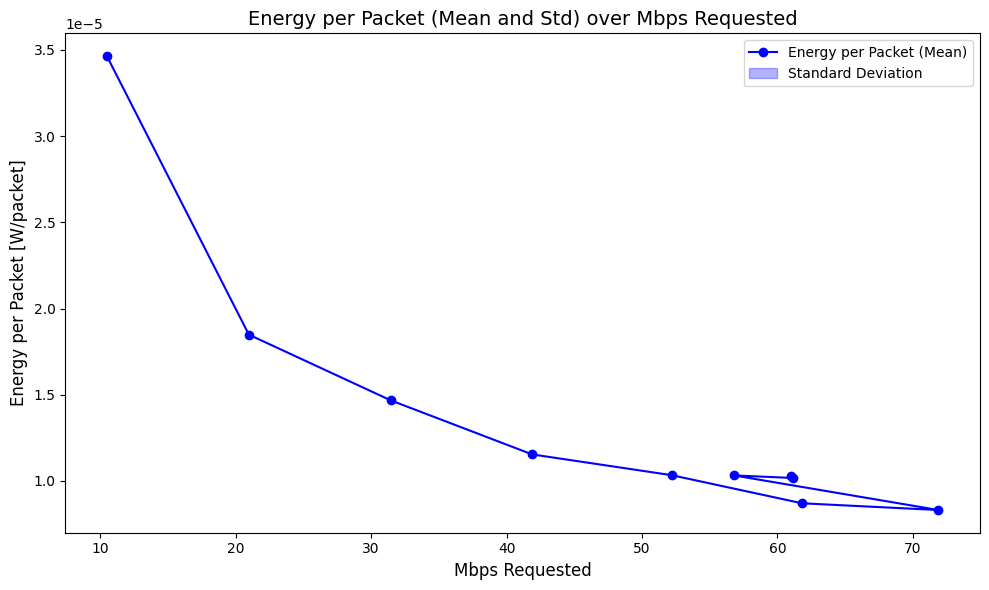

In [90]:
# Extract energy per packet mean and std from the per_throughput_stats DataFrame


energy_per_packet_mean = per_throughput_stats[('energy x packet [W/packet]', 'mean')]
energy_per_packet_std = per_throughput_stats[('energy x packet [W/packet]', 'std')]
throughput = per_throughput_stats[('avg Mbps effectively received at server','mean')]

# Plot the energy per packet (mean) with standard deviation
plt.figure(figsize=(10, 6))

# Plot the energy per packet mean
plt.plot(throughput, energy_per_packet_mean, label='Energy per Packet (Mean)', color='blue', marker='o')

# Add shaded area for standard deviation
plt.fill_between(throughput, 
                 energy_per_packet_mean - energy_per_packet_std, 
                 energy_per_packet_mean + energy_per_packet_std, 
                 color='blue', alpha=0.3, label='Standard Deviation')

# Add labels and title
plt.title('Energy per Packet (Mean and Std) over Mbps Requested', fontsize=14)
plt.xlabel('Mbps Requested', fontsize=12)
plt.ylabel('Energy per Packet [W/packet]', fontsize=12)

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


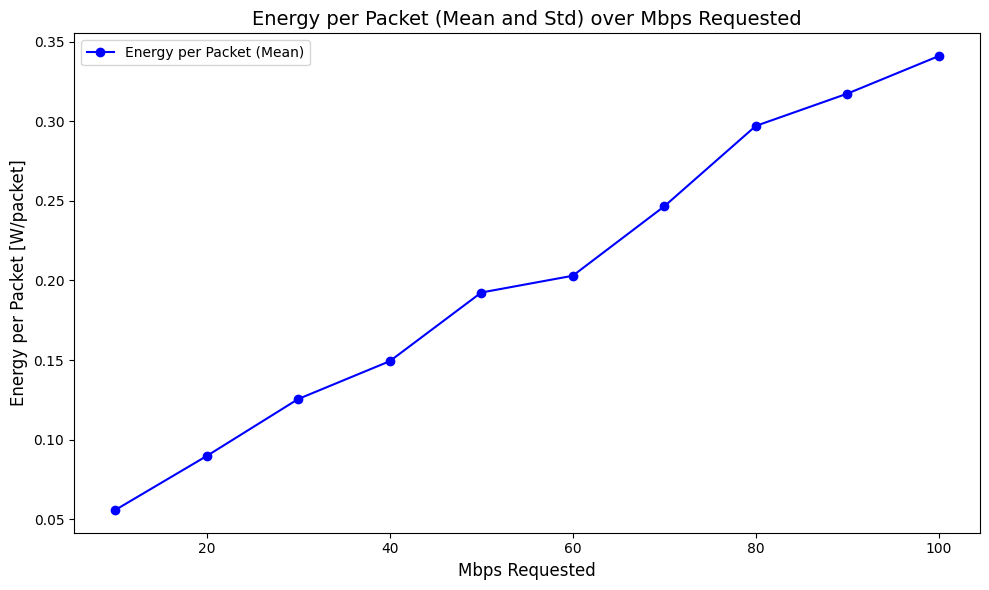

In [95]:
# Extract energy per packet mean and std from the per_throughput_stats DataFrame


energy_per_packet_cu = per_throughput_stats[('avg CU power consumption [W]', 'mean')]
# energy_per_packet_std = per_throughput_stats[('avg CU power consumption [W]', 'std')]
throughput = per_throughput_stats['Mbps requested']

# Plot the energy per packet (mean) with standard deviation
plt.figure(figsize=(10, 6))

# Plot the energy per packet mean
plt.plot(throughput, energy_per_packet_cu, label='Energy per Packet (Mean)', color='blue', marker='o')

# Add shaded area for standard deviation
# plt.fill_between(throughput, 
#                  energy_per_packet_mean - energy_per_packet_std, 
#                  energy_per_packet_mean + energy_per_packet_std, 
#                  color='blue', alpha=0.3, label='Standard Deviation')

# Add labels and title
plt.title('Energy per Packet (Mean and Std) over Mbps Requested', fontsize=14)
plt.xlabel('Mbps Requested', fontsize=12)
plt.ylabel('Energy per Packet [W/packet]', fontsize=12)

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


# Percentage of each component

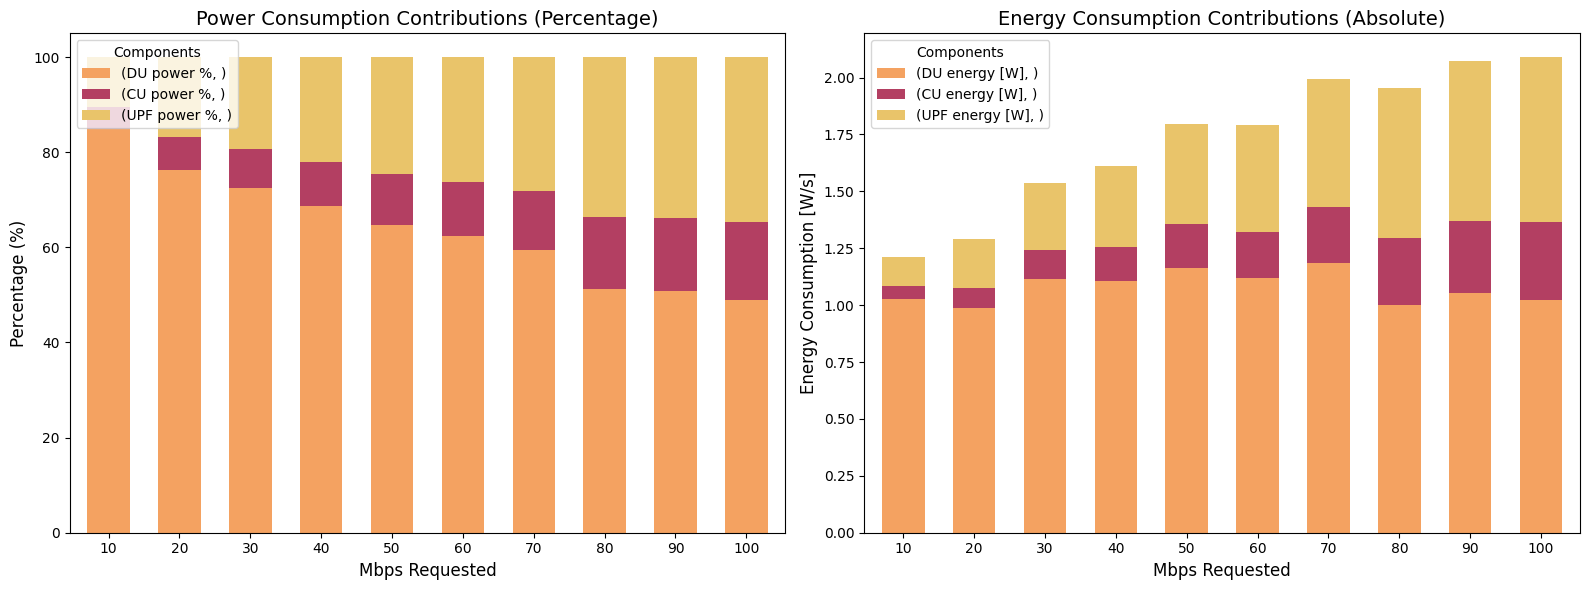

In [92]:
# Prepare data for percentage-based stacked bar chart
per_throughput_stats['DU power %'] = (
    per_throughput_stats[('avg DU power consumption [W]', 'mean')] / 
    per_throughput_stats[('total energy service [W]', 'mean')] * 100
)
# per_throughput_stats['NR-UE power %'] = (
#     per_throughput_stats[('avg NR-UE power consumption [W]', 'mean')] / 
#     per_throughput_stats[('total energy service [W]', 'mean')] * 100
# )
per_throughput_stats['CU power %'] = (
    per_throughput_stats[('avg CU power consumption [W]', 'mean')] / 
    per_throughput_stats[('total energy service [W]', 'mean')] * 100
)
per_throughput_stats['UPF power %'] = (
    per_throughput_stats[('avg UPF power consumption [W]', 'mean')] / 
    per_throughput_stats[('total energy service [W]', 'mean')] * 100
)

data_percentage_for_bar = per_throughput_stats[['DU power %', 'CU power %', 'UPF power %']]

# Prepare data for absolute energy consumption values
per_throughput_stats['DU energy [W]'] = per_throughput_stats[('avg DU power consumption [W]', 'mean')]
# per_throughput_stats['NR-UE energy [W]'] = per_throughput_stats[('avg NR-UE power consumption [W]', 'mean')]
per_throughput_stats['CU energy [W]'] = per_throughput_stats[('avg CU power consumption [W]', 'mean')]
per_throughput_stats['UPF energy [W]'] = per_throughput_stats[('avg UPF power consumption [W]', 'mean')]

data_absolute_for_bar = per_throughput_stats[['DU energy [W]',  'CU energy [W]', 'UPF energy [W]']]
# Define custom colors for the bars
colors = ['#F4A261', '#B33F62', '#E9C46A', '#2A9D8F']

# Create the merged plots with horizontal layout
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot percentage-based stacked bar chart
data_percentage_for_bar.plot(
    kind='bar',
    stacked=True,
    ax=axes[0],
    width=0.6,
    color=colors
)
axes[0].set_xticklabels(per_throughput_stats['Mbps requested'], rotation=0)
axes[0].set_title('Power Consumption Contributions (Percentage)', fontsize=14)
axes[0].set_xlabel('Mbps Requested', fontsize=12)
axes[0].set_ylabel('Percentage (%)', fontsize=12)
axes[0].legend(title='Components', loc='upper left')

# Plot absolute energy consumption stacked bar chart
data_absolute_for_bar.plot(
    kind='bar',
    stacked=True,
    ax=axes[1],
    width=0.6,
    color=colors
)
axes[1].set_xticklabels(per_throughput_stats['Mbps requested'], rotation=0)
axes[1].set_title('Energy Consumption Contributions (Absolute)', fontsize=14)
axes[1].set_xlabel('Mbps Requested', fontsize=12)
axes[1].set_ylabel('Energy Consumption [W/s]', fontsize=12)
axes[1].legend(title='Components', loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the merged plot
plt.show()


# Energy efficiency

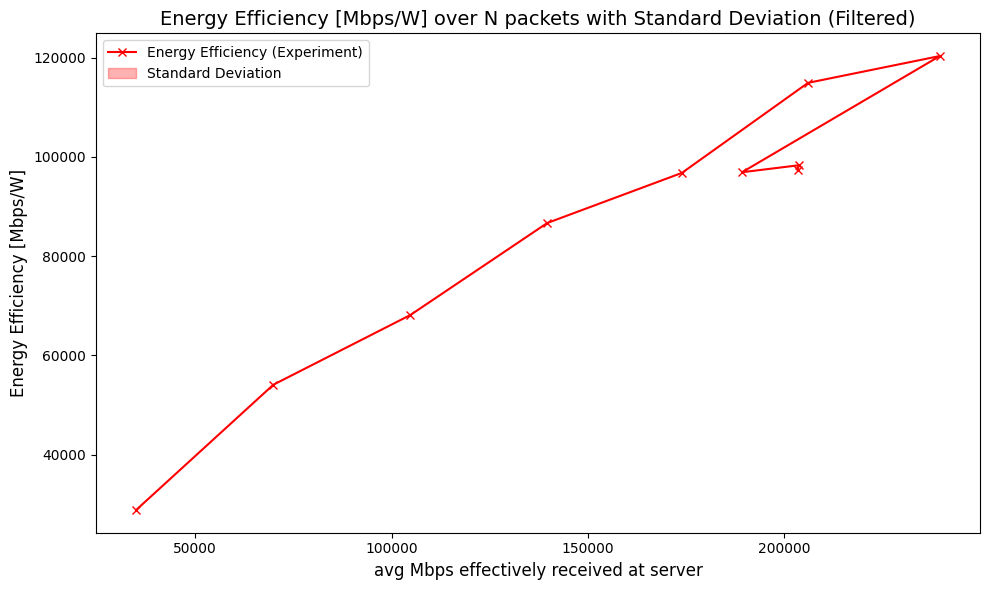

In [93]:
# Filter the data to only include 'Mbps requested' > 30
filtered_stats = per_throughput_stats[per_throughput_stats[('N packets','mean')] > 0]

# Calculate energy efficiency (Mbps/W) for baseline and experiment
filtered_stats['Energy Efficiency [Mbps/W]'] = filtered_stats[('N packets','mean')] / filtered_stats[('total energy service [W]', 'mean')]

# Calculate standard deviation for energy efficiency
# Energy efficiency standard deviation: std(N packets) / mean(total energy service [W])
filtered_stats['Energy Efficiency Std [Mbps/W]'] = filtered_stats[('total energy service [W]', 'std')]

# Plot the line plot for energy efficiency over N packets
plt.figure(figsize=(10, 6))

# Line plot for energy efficiency (mean) for experiment
plt.plot(
    filtered_stats[('N packets','mean')], 
    filtered_stats['Energy Efficiency [Mbps/W]'], 
    label='Energy Efficiency (Experiment)', 
    color='red', 
    marker='x'
)

# Add shaded area for standard deviation (shaded region)
plt.fill_between(
    filtered_stats[('N packets','mean')],
    filtered_stats['Energy Efficiency [Mbps/W]'] - filtered_stats['Energy Efficiency Std [Mbps/W]'],
    filtered_stats['Energy Efficiency [Mbps/W]'] + filtered_stats['Energy Efficiency Std [Mbps/W]'],
    color='red', alpha=0.3, label='Standard Deviation'
)

# Add labels and title
plt.title('Energy Efficiency [Mbps/W] over N packets with Standard Deviation (Filtered)', fontsize=14)
plt.xlabel('avg Mbps effectively received at server', fontsize=12)
plt.ylabel('Energy Efficiency [Mbps/W]', fontsize=12)

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
